# Predicting age of a child by looking at a hand Xray
The goal of this project is to identify the age of a child from an X-ray of their hand. This data was part of a competition http://rsnachallenges.cloudapp.net/competitions/4. We will build a model inspired by the one used by the winners of the competition. You will also borrow ideas from this fast.ai notebook. https://github.com/fastai/fastai/blob/master/courses/dl2/cifar10-darknet.ipynb

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import torch
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import random

In [2]:
import cv2
import matplotlib.pyplot as plt 

## Data

To get the data you can install the kaggle api using: <br/>
`pip install kaggle` <br/>
To get the dataset you can use this command line. (If you don't provide a path you will find your data in /home/user/.kaggle/datasets/kmader/rsna-bone-age/ )<br/>
`kaggle datasets download -d kmader/rsna-bone-age -p PATH` <br/>

In [3]:
PATH = Path("/data/yinterian/rsna-bone-age/")
list(PATH.iterdir())

[PosixPath('/data/yinterian/rsna-bone-age/boneage-training-dataset.csv'),
 PosixPath('/data/yinterian/rsna-bone-age/boneage-training-dataset')]

In [4]:
! head /data/yinterian/rsna-bone-age/boneage-training-dataset.csv

id,boneage,male
1377,180,False
1378,12,False
1379,94,False
1380,120,True
1381,82,False
1382,138,True
1383,150,True
1384,156,True
1385,36,True


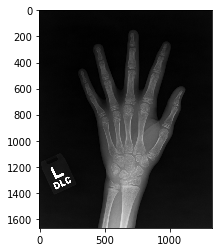

In [5]:
path = PATH/"boneage-training-dataset/9977.png"
im = cv2.imread(str(path))  #.astype(np.float32)/255
plt.imshow(im, cmap='gray')

In [ ]:
im = cv2.imread(str(path))  #.astype(np.float32)/255
im.shape

In [ ]:
# let's look at the typical size of these images
path = PATH/"boneage-training-dataset"
files = list(path.iterdir())[:200]
dims = [cv2.imread(str(p)).shape for p in files]
dims[:10]

In [ ]:
ratios = [x[0]/x[1] for x in dims]

Here is a presentation with EDA on this data
https://alxndrkalinin.github.io/pdf/2017-12_CFT_BoneAge.pdf

## Data augmentation
The winners of the competition used real-time image augmentation consisting of horizontal/vertical translation, zoom, and rotation of 20 percent/degrees as well as horizontal flip. They use 500x500 images.

In [6]:
# modified from fast.ai
def crop(im, r, c, target_r, target_c): return im[r:r+target_r, c:c+target_c]

def random_crop(x, target_r, target_c):
    r,c,*_ = x.shape
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(rand_r*(r - target_r)).astype(int)
    start_c = np.floor(rand_c*(c - target_c)).astype(int)
    return crop(x, start_r, start_c, target_r, target_c)

def rotate_cv(im, deg, mode=cv2.BORDER_REFLECT, interpolation=cv2.INTER_AREA):
    """ Rotates an image by deg degrees"""
    r,c,*_ = im.shape
    M = cv2.getRotationMatrix2D((c/2,r/2),deg,1)
    return cv2.warpAffine(im,M,(c,r), borderMode=mode, flags=cv2.WARP_FILL_OUTLIERS+interpolation)

### Resize, horizontal and vertical translations

In [ ]:
# resize desforms the image a bit
# note that by resizing to a larger number and random cropping we are doing horizontal and vertical translations
# we should try just center cropping the image instead of resizing
path = PATH/"boneage-training-dataset/9977.png"
im = cv2.imread(str(path))
im = cv2.resize(im, (550, 550))
im = random_crop(im, 500, 500)
plt.imshow(im, cmap='gray')

### Random Rotation (-10, 10) 

In [ ]:
rdeg = (np.random.random()-.50)*20
print(rdeg)
im_rot = rotate_cv(im, rdeg)
plt.imshow(im_rot, cmap='gray')

### Horizontal Flip

In [ ]:
im_f = np.fliplr(im)
plt.imshow(im_f, cmap='gray')

## Split train and validation

In [9]:
df = pd.read_csv(PATH/"boneage-training-dataset.csv")
train = df.sample(frac=0.8, random_state=3).copy()
valid = df.drop(train.index).copy()

## Dataset

In [24]:
class BoneAgeDataset(Dataset):
    def __init__(self, df, transforms=True):
        self.path_to_images = PATH/"boneage-training-dataset/"
        self.transforms = transforms
        self.df = df
        
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        path = str(self.path_to_images) + "/" + str(row["id"]) + ".png"
        y = row["boneage"]
        x = cv2.imread(str(path)).astype(np.float32)/255
        if self.transforms:
            x = cv2.resize(x, (330, 330))
            x = random_crop(x, 300, 300)
            rdeg = (np.random.random()-.50)*20
            x = rotate_cv(x, rdeg)
            if np.random.random() > 0.8: x = np.fliplr(x).copy() 
        else:
            x = cv2.resize(x, (300, 300))
        x = x[:,:,0]
        return x[None], y

In [11]:
train_ds = BoneAgeDataset(train)
valid_ds = BoneAgeDataset(valid, transforms=False)

In [12]:
batch_size = 16
train_dl = DataLoader(train_ds, batch_size=batch_size)
valid_dl = DataLoader(valid_ds, batch_size=batch_size)

In [ ]:
# run this multiple times to get different images
x, y = train_ds[10]
plt.imshow(x[0], cmap='gray')

In [ ]:
x.shape

## Model
This model is adapted from fast.ai

In [28]:
# From fast.ai
class Flatten(nn.Module):
    def __init__(self): super().__init__()
    def forward(self, x): return x.view(x.size(0), -1)

In [27]:
# From fast.ai
def conv_layer(ni, nf, ks=3, stride=1):
    return nn.Sequential(
        nn.Conv2d(ni, nf, kernel_size=ks, bias=False, stride=stride, padding=ks//2),
        nn.BatchNorm2d(nf, momentum=0.01),
        nn.LeakyReLU(negative_slope=0.1, inplace=True))

In [25]:
class ResLayer(nn.Module):
    def __init__(self, ni):
        super().__init__()
        self.conv1=conv_layer(ni, ni//2, ks=1)
        self.conv2=conv_layer(ni//2, ni, ks=3)
        
    def forward(self, x): return x.add(self.conv2(self.conv1(x)))

In [26]:
class Darknet(nn.Module):
    def make_group_layer(self, ch_in, num_blocks, stride=1):
        return [conv_layer(ch_in, ch_in*2,stride=stride)
               ] + [(ResLayer(ch_in*2)) for i in range(num_blocks)]

    def __init__(self, num_blocks, nf=32):
        super().__init__()
        layers = [conv_layer(1, nf, ks=3, stride=1)]
        for i,nb in enumerate(num_blocks):
            layers += self.make_group_layer(nf, nb, stride=2)
            nf *= 2
        layers += [nn.AdaptiveAvgPool2d(1), Flatten(), nn.Linear(nf, 1)]
        self.layers = nn.Sequential(*layers)
    
    def forward(self, x): return self.layers(x)

In [17]:
m = Darknet([1, 2, 4, 6, 3])

In [ ]:
m = m.cuda()

In [ ]:
x,y = next(iter(train_dl))
x = Variable(x).cuda().float()
y = Variable(y).cuda().float()

In [ ]:
x.shape

In [ ]:
m(x).shape

In [ ]:
m

## Train
We will optimize the mean absolute error (MAE). (reduced the learning rate by 20% after 10 epochs of plateau.)

In [18]:
def get_optimizer(model, lr = 0.01, wd = 0.0):
    parameters = filter(lambda p: p.requires_grad, model.parameters())
    optim = torch.optim.Adam(parameters, lr=lr, weight_decay=wd)
    return optim

In [19]:
def train_model(model, optim, train_dl=train_dl):
    model.train()
    total = 0
    sum_loss = 0
    for i, (x, y) in enumerate(train_dl):
        batch = x.shape[0]
        x = Variable(x).cuda().float()
        y = Variable(y).cuda().float()
        
        out = model(x)
        loss = F.l1_loss(out, y)
        
        optim.zero_grad()
        loss.backward()
        optim.step()
        total += batch
        sum_loss += batch*(loss.data[0])
    return sum_loss/total

In [20]:
def val_loss(model, valid_dl):
    model.eval()
    total = 0
    sum_loss = 0
    for i, (x, y) in enumerate(valid_dl):
        batch = x.shape[0]
        x = Variable(x).cuda().float()
        y = Variable(y).cuda().float()
        out = model(x)
        loss = F.l1_loss(out, y)
        sum_loss += batch*(loss.data[0])
        total += batch
    print("val loss", sum_loss/total)
    return loss.data[0]

In [21]:
def train_loop(model, epochs, lr=0.01, wd=0.0):
    optim = get_optimizer(model, lr = lr, wd = wd)
    for i in range(epochs):
        loss = train_model(model, optim, train_dl)
        if i%5 == 1: print("loss ", loss)
    val_loss(model, valid_dl)

In [29]:
model = Darknet([1, 2, 4, 6, 3]).cuda()

In [ ]:
train_loop(model, epochs=40, lr=0.01, wd=0.0)

# References

* https://www.16bit.ai/blog/ml-and-future-of-radiology
* https://stanfordmedicine.app.box.com/s/vhq1zop1867gr9rwnan4byj8lfxue173
* https://github.com/fastai/fastai/blob/master/courses/dl2/cifar10-darknet.ipynb